In [1]:
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict

import numpy as np 
import pandas as pd
from sklearn import *
import lightgbm as lgb
from catboost import Pool,CatBoostRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

pd.set_option("display.precision", 8)

from functools import partial
import scipy as sp

import os
from sklearn.metrics import f1_score

import pywt 
from statsmodels.robust import mad

import scipy
from scipy import signal
from scipy.signal import butter, deconvolve, find_peaks, peak_widths, peak_prominences

from numpy.fft import *

import time
import math
from numba import jit
from math import log, floor
from sklearn.neighbors import KDTree

import itertools
import warnings
import time
import pywt
import os
import gc

train = pd.read_csv('/Users/siero5335/channel/train.csv')
test = pd.read_csv('/Users/siero5335/channel/test.csv')
train2 = pd.read_csv('/Users/siero5335/channel/train2.csv')
test2 = pd.read_csv('/Users/siero5335/channel/test2.csv')

sample_submission = pd.read_csv('/Users/siero5335/channel/sample_submission.csv')

train2 = train2.iloc[:,1]
test2 = test2.iloc[:,1]

train = pd.concat([train, train2], axis=1)
test = pd.concat([test, test2], axis=1)

In [2]:
train = train.drop('signal', axis = 1)
test = test.drop('signal', axis = 1)

train = train.rename(columns={'signal_chris': 'signal'})
test = test.rename(columns={'signal_chris': 'signal'})
                     

In [3]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def high_pass_filter(x, low_cutoff=1000, sample_rate=10000):

    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    print(norm_low_cutoff)
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

def denoise_signal( x, wavelet='db4', level=1):
    
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    sigma = (1/0.6745) * maddest( coeff[-level] )
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    return pywt.waverec( coeff, wavelet, mode='per' )

train['signal_wave'] = denoise_signal(train['signal'])
test['signal_wave'] = denoise_signal(test['signal'])

In [4]:
def filter_signal(signal, threshold=1e8):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

train['signal_FFT_1e5'] = filter_signal(train['signal'], threshold=5e3)
test['signal_FFT_1e5'] = filter_signal(test['signal'], threshold=5e3)

In [5]:
def _embed(x, order=3, delay=1):
    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

all = ['perm_entropy', 'spectral_entropy', 'svd_entropy', 'app_entropy',
       'sample_entropy']


def perm_entropy(x, order=3, delay=1, normalize=False):
    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe

In [6]:
def _log_n(min_n, max_n, factor):
    max_i = int(floor(log(1.0 * max_n / min_n) / log(factor)))
    ns = [min_n]
    for i in range(max_i + 1):
        n = int(floor(min_n * (factor ** i)))
        if n > ns[-1]:
            ns.append(n)
    return np.array(ns, dtype=np.int64)

def _higuchi_fd(x, kmax):
    n_times = x.size
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    for k in range(1, kmax + 1):
        lm = np.empty((k,))
        for m in range(k):
            ll = 0
            n_max = floor((n_times - m - 1) / k)
            n_max = int(n_max)
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])
            ll /= k
            ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
        # Mean of lm
        m_lm = 0
        for m in range(k):
            m_lm += lm[m]
        m_lm /= k
        lk[k - 1] = m_lm
        x_reg[k - 1] = log(1. / k)
        y_reg[k - 1] = log(m_lm)
    higuchi, _ = _linear_regression(x_reg, y_reg)
    return higuchi


def higuchi_fd(x, kmax=10):
    x = np.asarray(x, dtype=np.float64)
    kmax = int(kmax)
    return _higuchi_fd(x, kmax)

def _linear_regression(x, y):
    n_times = x.size
    sx2 = 0
    sx = 0
    sy = 0
    sxy = 0
    for j in range(n_times):
        sx2 += x[j] ** 2
        sx += x[j]
        sxy += x[j] * y[j]
        sy += y[j]
    den = n_times * sx2 - (sx ** 2)
    num = n_times * sxy - sx * sy
    slope = num / den
    intercept = np.mean(y) - slope * np.mean(x)
    return slope, intercept

In [7]:
def katz_fd(x):
    x = np.array(x)
    dists = np.abs(np.ediff1d(x))
    ll = dists.sum()
    ln = np.log10(np.divide(ll, dists.mean()))
    aux_d = x - x[0]
    d = np.max(np.abs(aux_d[1:]))
    return np.divide(ln, np.add(ln, np.log10(np.divide(d, ll))))

In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        if col!='open_channels':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
def feature_selection(df : pd.DataFrame,
                      df_test : pd.DataFrame,
                      subtract_only : Optional[bool]=True,
                      idx_cols : List=['time'],
                      target_col : List=['open_channels']) -> Tuple[pd.DataFrame , pd.DataFrame]:
    
    drops = df.columns[df.isna().sum()>25000]
    df = df.drop(drops, axis=1)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    gc.collect()
    if subtract_only == False:
        corrcoef_cols = [col for col in df.columns.tolist() if col not in (idx_cols+target_col)]
        first=dict(); second=dict(); third=dict()
        for col in corrcoef_cols:
            ss = np.corrcoef(df[col], df['open_channels'])[0, 1]
            first[col] = ss
            ss = np.corrcoef(df[col]-df['signal'], df['open_channels'])[0, 1]
            second[col] = ss
            ss = np.corrcoef(df[col]*df['signal'], df['open_channels'])[0, 1]
            third[col] = ss
        corr_df = pd.DataFrame.from_dict(
            {
            'Base':first, 
            'Signal-Subtracted': second,
            'Signal-Multiplied': third
            }
        ).fillna(0).apply(np.abs).sort_values('Base', ascending=False)

        base_cols = corr_df.sort_values('Base', ascending=False).head(100).index.tolist()
        multiply_cols = corr_df.sort_values('Signal-Multiplied', ascending=False).head(10).index.tolist()
        subtract_cols = corr_df.sort_values('Signal-Subtracted', ascending=False).head(25).index.tolist()
        display(corr_df.sort_values('Base', ascending=False).tail(50))
        all_cols = list(set(base_cols + multiply_cols + subtract_cols + idx_cols + target_col))
        all_cols_test = list(set(base_cols + multiply_cols + subtract_cols + idx_cols))   
        drops = list(set(multiply_cols + subtract_cols)-set(base_cols))
        df = df[all_cols]
        df_test = df_test[all_cols_test]
    
        for col in multiply_cols:
            df[col+'_m'] = df[col] * df['signal']
            df_test[col+'_m'] = df_test[col] * df_test['signal']        

        df = df.drop(drops, axis=1)
    else:
        not_imp = ['stdbach_slice2_msignal', 'min_FFT_1e5batch_msignal', 'skewbach_slice2_msignal']
        subtract_cols = list(set(df.columns.tolist())-set(idx_cols + target_col + not_imp))

    df = reduce_mem_usage(df, False)
    df_test = reduce_mem_usage(df_test, False)

    gc.collect()
    return df, df_test

In [10]:
def p1( x : pd.Series) -> pd.Series : return x.quantile(0.01)
def p5(x : pd.Series) -> pd.Series : return x.quantile(0.05)
def p95( x : pd.Series) -> pd.Series : return x.quantile(0.95)
def p99(x : pd.Series) -> pd.Series : return x.quantile(0.99)

In [11]:
zscore = lambda x: (x - x.mean()) / x.std()

window_sizes = [50, 100, 1000, 5000, 10000, 25000]

for window in window_sizes:
    train["rolling_mean_" + str(window)] = train['signal'].rolling(window=window).mean()
    train["rolling_std_" + str(window)] = train['signal'].rolling(window=window).std()
    train["rolling_min_" + str(window)] = train['signal'].rolling(window=window).min()
    train["rolling_max_" + str(window)] = train['signal'].rolling(window=window).max()

for window in window_sizes:
    test["rolling_mean_" + str(window)] = test['signal'].rolling(window=window).mean()
    test["rolling_std_" + str(window)] = test['signal'].rolling(window=window).std()
    test["rolling_min_" + str(window)] = test['signal'].rolling(window=window).min()
    test["rolling_max_" + str(window)] = test['signal'].rolling(window=window).max()

def features(df):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 25_000
    df['batch_index'] = df.index  - (df.batch * 25_000)
    df['batch_slices'] = df['batch_index']  // 5_000
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    for c in ['batch','batch_slices2']:
        d = {}
                                            
        d['mean'+c] = df.groupby([c])['signal'].mean()
        d['median'+c] = df.groupby([c])['signal'].median()
        d['max'+c] = df.groupby([c])['signal'].max()
        d['min'+c] = df.groupby([c])['signal'].min()
        d['std'+c] = df.groupby([c])['signal'].std()
        d['skew'+c] = df.groupby([c])['signal'].skew()
        
        d['q1'+c] = df.groupby([c])['signal'].apply(lambda x:p1(x))
        d['q5'+c] = df.groupby([c])['signal'].apply(lambda x:p5(x))
        d['q95'+c] = df.groupby([c])['signal'].apply(lambda x:p95(x))       
        d['q99'+c] = df.groupby([c])['signal'].apply(lambda x:p99(x))                   
        
        d['signal_batch'+c] = df.groupby([c])['signal'].transform(zscore)
        d['perm'+c] = df.groupby([c])['signal'].apply(lambda x:perm_entropy(x))
        d['higuchi'+c] = df.groupby([c])['signal'].apply(lambda x:higuchi_fd(x))
        d['katz'+c] = df.groupby([c])['signal'].apply(lambda x:katz_fd(x))
                
        d['mean_abs_chg'+c] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
        for v in d:
            df[v] = df[c].map(d[v].to_dict())
        df['range'+c] = df['max'+c] - df['min'+c]
        df['maxtomin'+c] = df['max'+c] / df['min'+c]
        df['abs_avg'+c] = (df['abs_min'+c] + df['abs_max'+c]) / 2
    
    #add shifts
    df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
    df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1'][i] = np.nan
    for i in df[df['batch_index']==24999].index:
        df['signal_shift_-1'][i] = np.nan
        
    df['signal_shift_wave_+1'] = [0,] + list(df['signal_wave'].values[:-1])
    df['signal_shift_wave_-1'] = list(df['signal_wave'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_wave_+1'][i] = np.nan
    for i in df[df['batch_index']==24999].index:
        df['signal_shift_wave_-1'][i] = np.nan
        
        
    df['signal_shift_+1_FFT'] = [0,] + list(df['signal_FFT_1e5'].values[:-1])
    df['signal_shift_-1_FFT'] = list(df['signal_FFT_1e5'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1_FFT'][i] = np.nan
    for i in df[df['batch_index']==24999].index:
        df['signal_shift_-1_FFT'][i] = np.nan
        
    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2', 'signal_wave']]:
        df[c+'_msignal'] = df[c] - df['signal']
        
    return df

train = features(train)
test = features(test)

train['signal_shift+2'] = train.groupby(['batch']).shift(2)['signal']
test['signal_shift+2'] = test.groupby(['batch']).shift(2)['signal']
train['signal_shift-2'] = train.groupby(['batch']).shift(-2)['signal']
test['signal_shift-2'] = test.groupby(['batch']).shift(-2)['signal']


train['signal_shift+2_wave_-1'] = train.groupby(['batch']).shift(2)['signal_wave']
test['signal_shift+2_wave_-1'] = test.groupby(['batch']).shift(2)['signal_wave']
train['signal_shift-2_wave_-1'] = train.groupby(['batch']).shift(-2)['signal_wave']
test['signal_shift-2_wave_-1'] = test.groupby(['batch']).shift(-2)['signal_wave']


train['signal_shift+2_FFT'] = train.groupby(['batch']).shift(2)['signal_FFT_1e5']
test['signal_shift+2_FFT'] = test.groupby(['batch']).shift(2)['signal_FFT_1e5']
train['signal_shift-2_FFT'] = train.groupby(['batch']).shift(-2)['signal_FFT_1e5']
test['signal_shift-2_FFT'] = test.groupby(['batch']).shift(-2)['signal_FFT_1e5']

train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

train_y = train['open_channels']

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/siero5335/opt/anaconda3/lib/python3.7/site

In [12]:
train.head()

,time,open_channels,signal,signal_wave,signal_FFT_1e5,rolling_mean_50,rolling_std_50,rolling_min_50,rolling_max_50,rolling_mean_100,...,signal_shift_wave_+1_msignal,signal_shift_wave_-1_msignal,signal_shift_+1_FFT_msignal,signal_shift_-1_FFT_msignal,signal_shift+2,signal_shift-2,signal_shift+2_wave_-1,signal_shift-2_wave_-1,signal_shift+2_FFT,signal_shift-2_FFT
0.0,0.0001,0,-2.7600,-2.49931891,0.36733109,0.0,0.0,0.0,0.0,0.0,...,0.00000000,-0.78580580,0.00000000,3.12709392,0.0000,-2.4074,0.00000000,-0.95419929,0.00000000,0.36685675
1.0,0.0002,0,-2.8557,-3.54580580,0.36709392,0.0,0.0,0.0,0.0,0.0,...,0.35638109,1.90150071,3.22303109,3.22255675,0.0000,-3.1404,0.00000000,-1.32866244,0.00000000,0.36661957
2.0,0.0003,0,-2.4074,-0.95419929,0.36685675,0.0,0.0,0.0,0.0,0.0,...,-1.13840580,1.07873756,2.77449392,2.77401957,-2.7600,-3.1525,-2.49931891,-3.60514371,0.36733109,0.36638240
3.0,0.0004,0,-3.1404,-1.32866244,0.36661957,0.0,0.0,0.0,0.0,0.0,...,2.18620071,-0.46474371,3.50725675,3.50678240,-2.8557,-2.6418,-3.54580580,-4.06727689,0.36709392,0.36614523
4.0,0.0005,0,-3.1525,-3.60514371,0.36638240,0.0,0.0,0.0,0.0,0.0,...,1.82383756,-0.91477689,3.51911957,3.51864523,-2.4074,-2.6993,-0.95419929,-3.59025109,0.36685675,0.36590806


In [13]:
test.head()

,time,signal,signal_wave,signal_FFT_1e5,rolling_mean_50,rolling_std_50,rolling_min_50,rolling_max_50,rolling_mean_100,rolling_std_100,...,signal_shift_wave_+1_msignal,signal_shift_wave_-1_msignal,signal_shift_+1_FFT_msignal,signal_shift_-1_FFT_msignal,signal_shift+2,signal_shift-2,signal_shift+2_wave_-1,signal_shift-2_wave_-1,signal_shift+2_FFT,signal_shift-2_FFT
5000000.0,500.0001,-2.64983,-2.70763568,-2.68908707,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000000,-0.05779149,0.00000000,-0.03925862,0.00000,-2.86009,0.00000000,-2.70760720,0.00000000,-2.68909018
5000001.0,500.0002,-2.84946,-2.70762149,-2.68908862,0.0,0.0,0.0,0.0,0.0,0.0,...,0.14182432,0.14185280,0.16037293,0.16036982,0.00000,-2.43512,0.00000000,-2.70759352,0.00000000,-2.68909172
5000002.0,500.0003,-2.86009,-2.70760720,-2.68909018,0.0,0.0,0.0,0.0,0.0,0.0,...,0.15246851,0.15249648,0.17100138,0.17099828,-2.64983,-2.61565,-2.70763568,-2.70758051,-2.68908707,-2.68909327
5000003.0,500.0004,-2.43512,-2.70759352,-2.68909172,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.27248720,-0.27246051,-0.25397018,-0.25397327,-2.84946,-2.56608,-2.70762149,-2.70756785,-2.68908862,-2.68909481
5000004.0,500.0005,-2.61565,-2.70758051,-2.68909327,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.09194352,-0.09191785,-0.07344172,-0.07344481,-2.86009,-2.73801,-2.70760720,-2.70755576,-2.68909018,-2.68909635


In [14]:
#train.to_csv('/Users/siero5335/channel/train_mod.csv')
#test.to_csv('/Users/siero5335/channel/test_mod.csv')

In [15]:
col = [c for c in train.columns if c not in ['time', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]

train = train[col]
test = test[col]

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [16]:
oof = np.zeros(len(train))
prediction = np.zeros(len(test))
scores = []

params = {'learning_rate': 0.05, 'max_depth': -1, 'num_leaves':2**7+1, 'metric': 'mae', 'random_state': 7, 'n_jobs':-1} 

for fold_n, (train_index, valid_index) in enumerate(folds.split(train)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    
    model = lgb.LGBMRegressor(**params, n_estimators = 5000)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
            verbose=100, early_stopping_rounds=100)

    y_pred_valid = model.predict(X_valid)
    y_pred = model.predict(test, num_iteration=model.best_iteration_)

    oof[valid_index] = y_pred_valid.reshape(-1,)
    scores.append(mean_absolute_error(y_valid, y_pred_valid))

    prediction += y_pred

prediction /= n_fold

Fold 0 started at Sat Mar  7 22:32:17 2020
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.0573425	valid_1's l1: 0.0576844
[200]	training's l1: 0.049572	valid_1's l1: 0.050356
[300]	training's l1: 0.0490584	valid_1's l1: 0.050221
[400]	training's l1: 0.0485893	valid_1's l1: 0.0501194
[500]	training's l1: 0.0481991	valid_1's l1: 0.0500814
[600]	training's l1: 0.0478252	valid_1's l1: 0.0500517
[700]	training's l1: 0.0474396	valid_1's l1: 0.0500077
[800]	training's l1: 0.0470583	valid_1's l1: 0.0499617
[900]	training's l1: 0.0466889	valid_1's l1: 0.049916
[1000]	training's l1: 0.0463369	valid_1's l1: 0.0498782
[1100]	training's l1: 0.0459877	valid_1's l1: 0.049841
[1200]	training's l1: 0.0456613	valid_1's l1: 0.0498188
[1300]	training's l1: 0.0453427	valid_1's l1: 0.0497908
[1400]	training's l1: 0.0450502	valid_1's l1: 0.0497735
[1500]	training's l1: 0.0447442	valid_1's l1: 0.0497498
[1600]	training's l1: 0.0444593	valid_1's l1: 0.0497414
[1700]	traini

In [17]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize F1 (Macro) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _f1_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

        return -f1_score(y, X_p, average = 'macro')

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._f1_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [18]:
optR = OptimizedRounder()
optR.fit(oof.reshape(-1,), train_y)
coefficients = optR.coefficients()
print(coefficients)

[0.51533144 1.50854369 2.48112631 3.4837511  4.48906138 5.46175831
 6.52350707 7.51190468 8.46812123 9.46811952]


In [19]:
opt_preds = optR.predict(oof.reshape(-1,), coefficients)
f1_score(train_y, opt_preds, average = 'macro')

0.9380334161585566

In [20]:
prediction[prediction <= coefficients[0]] = 0
prediction[np.where(np.logical_and(prediction > coefficients[0], prediction <= coefficients[1]))] = 1
prediction[np.where(np.logical_and(prediction > coefficients[1], prediction <= coefficients[2]))] = 2
prediction[np.where(np.logical_and(prediction > coefficients[2], prediction <= coefficients[3]))] = 3
prediction[np.where(np.logical_and(prediction > coefficients[3], prediction <= coefficients[4]))] = 4
prediction[np.where(np.logical_and(prediction > coefficients[4], prediction <= coefficients[5]))] = 5
prediction[np.where(np.logical_and(prediction > coefficients[5], prediction <= coefficients[6]))] = 6
prediction[np.where(np.logical_and(prediction > coefficients[6], prediction <= coefficients[7]))] = 7
prediction[np.where(np.logical_and(prediction > coefficients[7], prediction <= coefficients[8]))] = 8
prediction[np.where(np.logical_and(prediction > coefficients[8], prediction <= coefficients[9]))] = 9
prediction[prediction > coefficients[9]] = 10

In [21]:
sample_submission['open_channels'] = prediction.astype(np.int)
sample_submission.to_csv('submission_reg20200307_mae_5cv2.csv', index=False, float_format='%.4f')

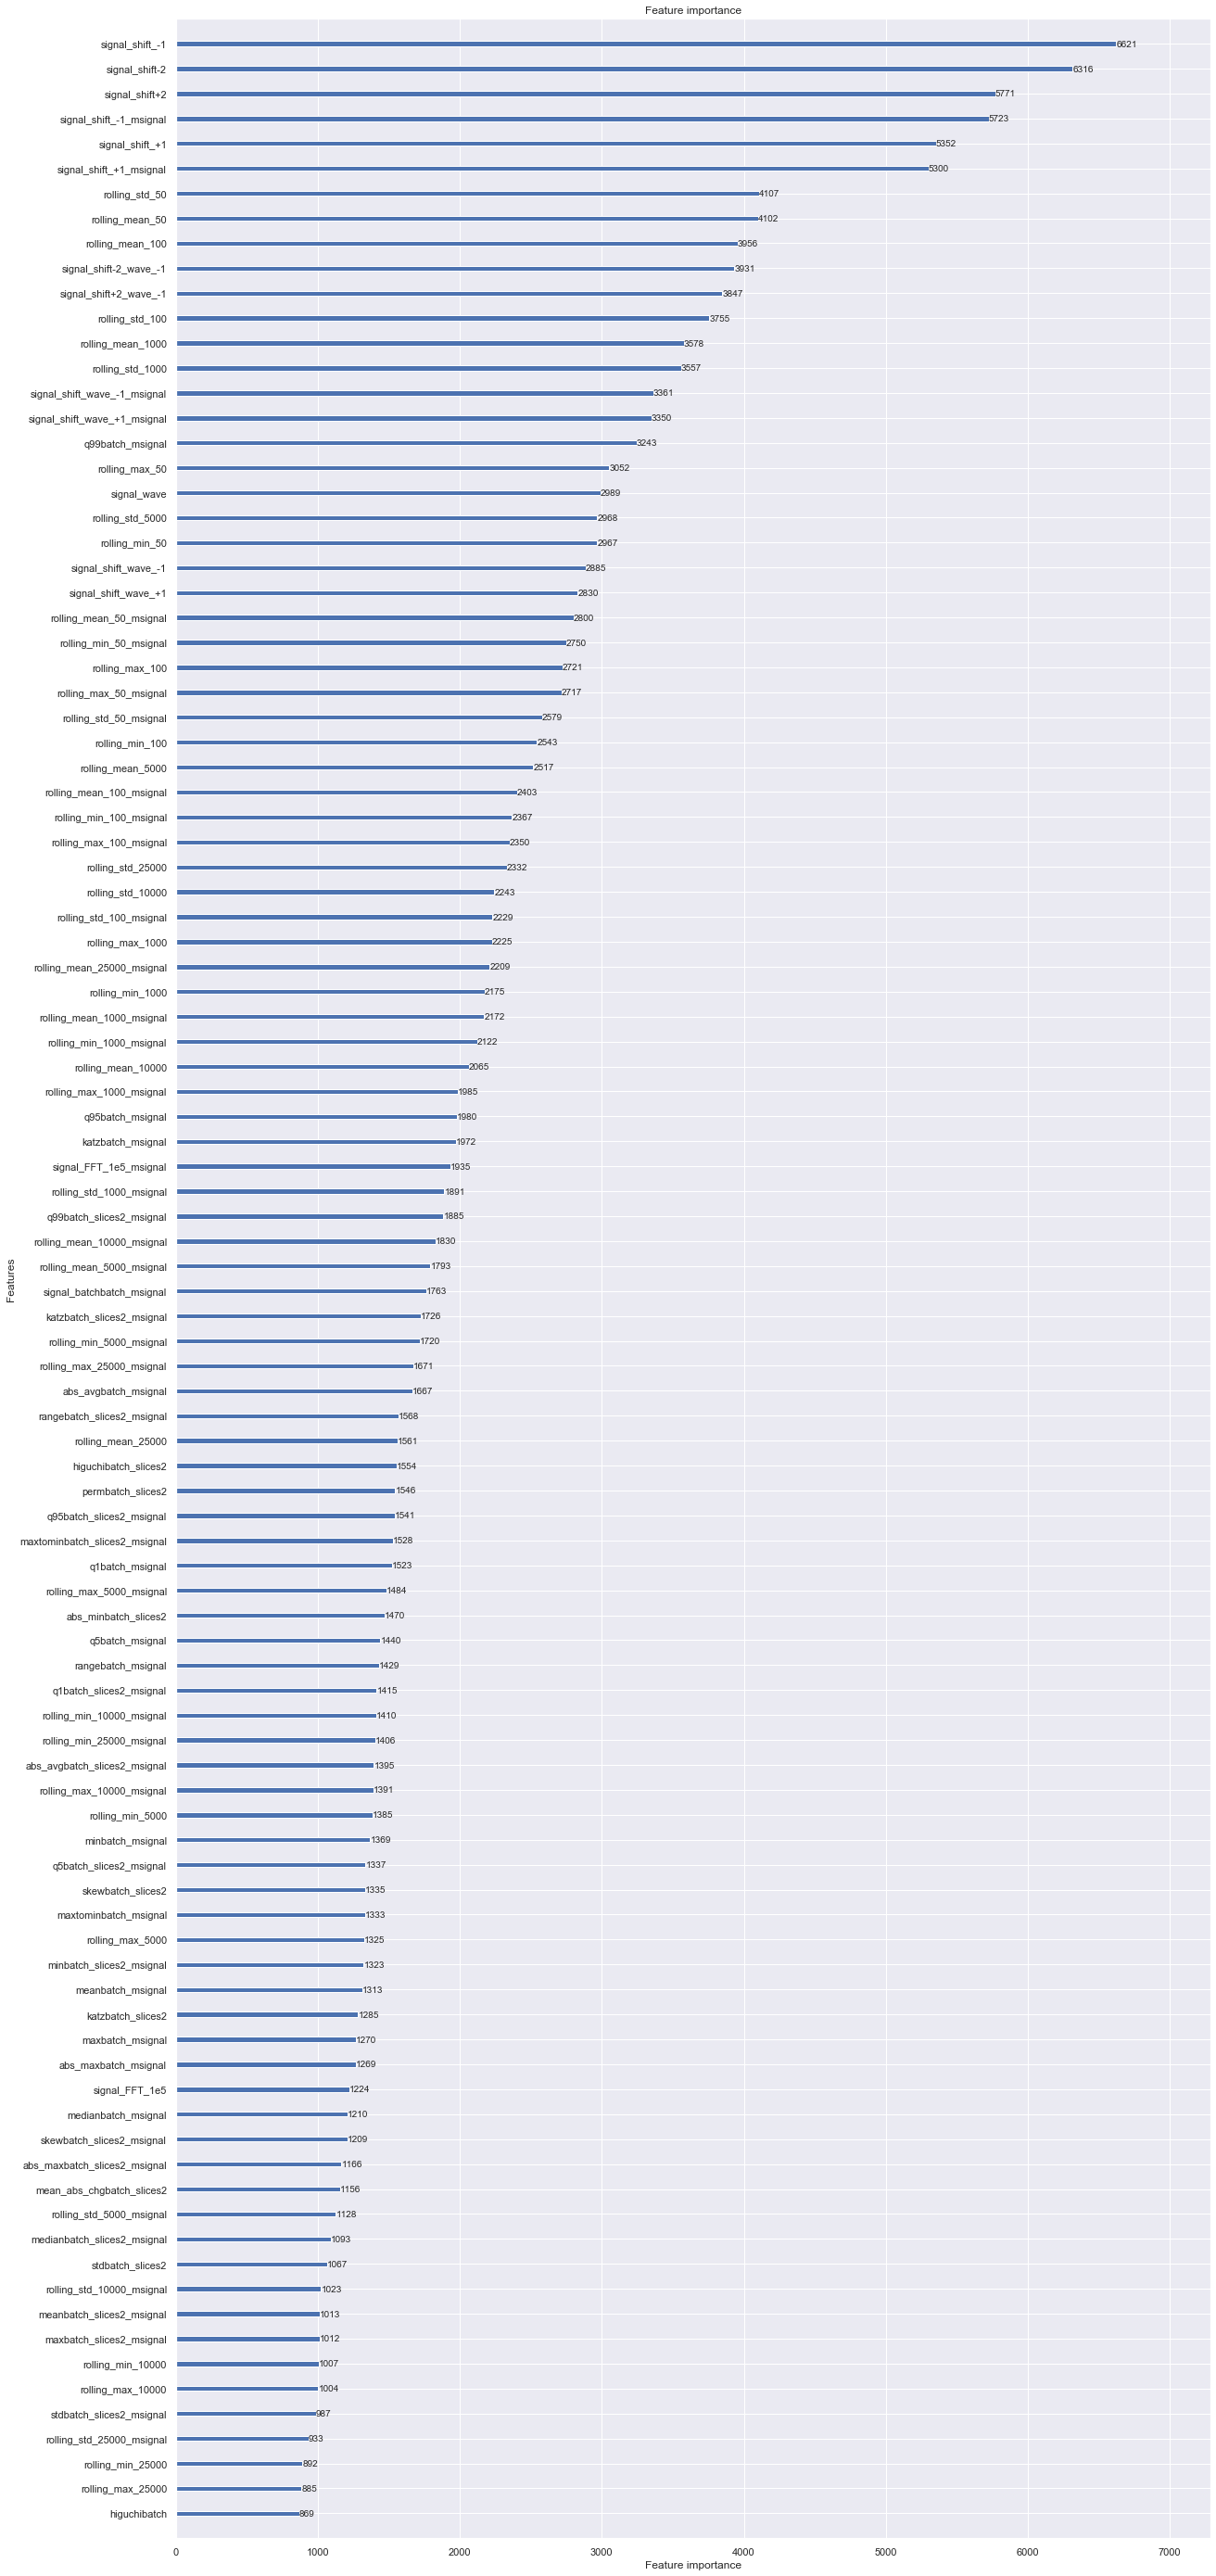

In [22]:
lgb.plot_importance(model,importance_type='split', max_num_features=100, figsize=(20, 50))